In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-whitegrid')
#sns.set_context("poster")


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, KFold
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

import time as time

from xgboost import XGBClassifier

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

plt.rcParams["figure.figsize"] = (16, 4)
plt.rcParams["xtick.labelsize"] = 12


In [2]:
adult =  pd.read_csv('adult.data.csv', header=None, names=['age','workclass','fnlwgt','education','education_num','marital_status','occupation','relationship','race','sex','capital_gain','capital_loss','hours_per_week','native_country','wage_class'])

In [3]:
adult.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
adult.describe()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [5]:
adult.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education_num      int64
marital_status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain       int64
capital_loss       int64
hours_per_week     int64
native_country    object
wage_class        object
dtype: object

In [6]:
categorical = [var for var in adult.columns if adult[var].dtype=='O']
print(categorical)

['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country', 'wage_class']


In [7]:
numerical = [var for var in adult.columns if adult[var].dtype !='O']
print(numerical)

['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']


In [8]:
adult.replace(to_replace=' ?', value=np.nan, inplace=True)

In [9]:
adult.isnull().mean()
# workclass, occupation, native_country have missing values

age               0.000000
workclass         0.056386
fnlwgt            0.000000
education         0.000000
education_num     0.000000
marital_status    0.000000
occupation        0.056601
relationship      0.000000
race              0.000000
sex               0.000000
capital_gain      0.000000
capital_loss      0.000000
hours_per_week    0.000000
native_country    0.017905
wage_class        0.000000
dtype: float64

In [10]:
# strip leading and trailing spaces from categorical columns
for col in categorical:
    adult[col] = adult[col].str.strip()

In [11]:
print(adult.shape[0])
print(adult.isnull().mean().loc['workclass'])

32561
0.05638647461687295


In [12]:
adult.workclass.value_counts()

Private             22696
Self-emp-not-inc     2541
Local-gov            2093
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64

In [13]:
# treat missing values in workclass column

workclass_missing_val_count = (adult.shape[0] * adult.isnull().mean().loc['workclass'])
print(workclass_missing_val_count)

# count of missing values is high. create a new label 'missing'

1836.0


In [14]:
adult.workclass.fillna('missing', inplace=True)

In [15]:
adult.workclass.value_counts()

Private             22696
Self-emp-not-inc     2541
Local-gov            2093
missing              1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64

In [16]:
adult.occupation.value_counts()

Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3770
Sales                3650
Other-service        3295
Machine-op-inspct    2002
Transport-moving     1597
Handlers-cleaners    1370
Farming-fishing       994
Tech-support          928
Protective-serv       649
Priv-house-serv       149
Armed-Forces            9
Name: occupation, dtype: int64

In [17]:
# treat missing values in occupation column

occupation_missing_val_count = (adult.shape[0] * adult.isnull().mean().loc['occupation'])
print(occupation_missing_val_count)

# count of missing values is high. create a new label 'missing'

1843.0


In [18]:
adult.occupation.fillna('missing', inplace=True)

In [19]:
adult.occupation.value_counts()

Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3770
Sales                3650
Other-service        3295
Machine-op-inspct    2002
missing              1843
Transport-moving     1597
Handlers-cleaners    1370
Farming-fishing       994
Tech-support          928
Protective-serv       649
Priv-house-serv       149
Armed-Forces            9
Name: occupation, dtype: int64

In [20]:
adult.native_country.value_counts()

United-States                 29170
Mexico                          643
Philippines                     198
Germany                         137
Canada                          121
Puerto-Rico                     114
El-Salvador                     106
India                           100
Cuba                             95
England                          90
Jamaica                          81
South                            80
China                            75
Italy                            73
Dominican-Republic               70
Vietnam                          67
Guatemala                        64
Japan                            62
Poland                           60
Columbia                         59
Taiwan                           51
Haiti                            44
Iran                             43
Portugal                         37
Nicaragua                        34
Peru                             31
France                           29
Greece                      

In [21]:
# treat missing values in native_country column

native_country_missing_val_count = (adult.shape[0] * adult.isnull().mean().loc['native_country'])
print(native_country_missing_val_count)

# count of missing values is high. create a new label 'missing'

583.0


In [22]:
adult.native_country.fillna('missing', inplace=True)

In [23]:
adult.native_country.value_counts()

United-States                 29170
Mexico                          643
missing                         583
Philippines                     198
Germany                         137
Canada                          121
Puerto-Rico                     114
El-Salvador                     106
India                           100
Cuba                             95
England                          90
Jamaica                          81
South                            80
China                            75
Italy                            73
Dominican-Republic               70
Vietnam                          67
Guatemala                        64
Japan                            62
Poland                           60
Columbia                         59
Taiwan                           51
Haiti                            44
Iran                             43
Portugal                         37
Nicaragua                        34
Peru                             31
Greece                      

In [24]:
adult.isna().mean()
# all missing values has been treated

age               0.0
workclass         0.0
fnlwgt            0.0
education         0.0
education_num     0.0
marital_status    0.0
occupation        0.0
relationship      0.0
race              0.0
sex               0.0
capital_gain      0.0
capital_loss      0.0
hours_per_week    0.0
native_country    0.0
wage_class        0.0
dtype: float64

In [25]:
# take care of rare labels in all categorical columns
# for xgboost rare column treatment is not required

In [26]:
categorical = [var for var in adult.columns if adult[var].dtype=='O']
print(categorical)

['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country', 'wage_class']


In [27]:
adult.workclass.value_counts()

Private             22696
Self-emp-not-inc     2541
Local-gov            2093
missing              1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64

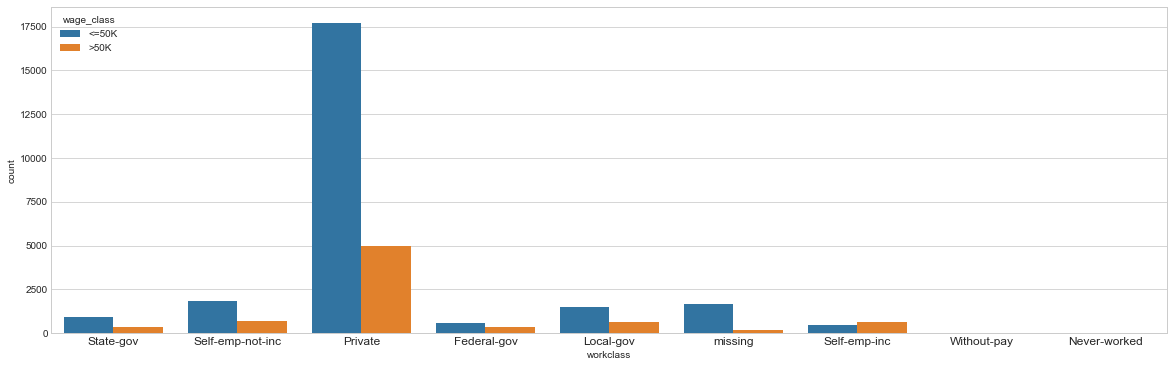

In [28]:
plt.figure(figsize=(20,6))
sns.countplot(data=adult, x='workclass', hue='wage_class')

In [29]:
#combine without-pay and never-worked --> no-emp
#combine state-gov, local-gov and Federal-gov --> gov-emp
#combine self-emp-not-inc and self-emp-inc --> self-emp

In [30]:
adult.workclass.replace(['Without-pay','Never-worked','Self-emp-inc','Self-emp-not-inc','State-gov','Federal-gov','Local-gov'],
                       ['not-emp','not-emp','self-emp','self-emp','gov-emp','gov-emp','gov-emp'], inplace=True)

In [31]:
adult.workclass.value_counts()

Private     22696
gov-emp      4351
self-emp     3657
missing      1836
not-emp        21
Name: workclass, dtype: int64

In [32]:
adult.education.value_counts()

HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           333
1st-4th           168
Preschool          51
Name: education, dtype: int64

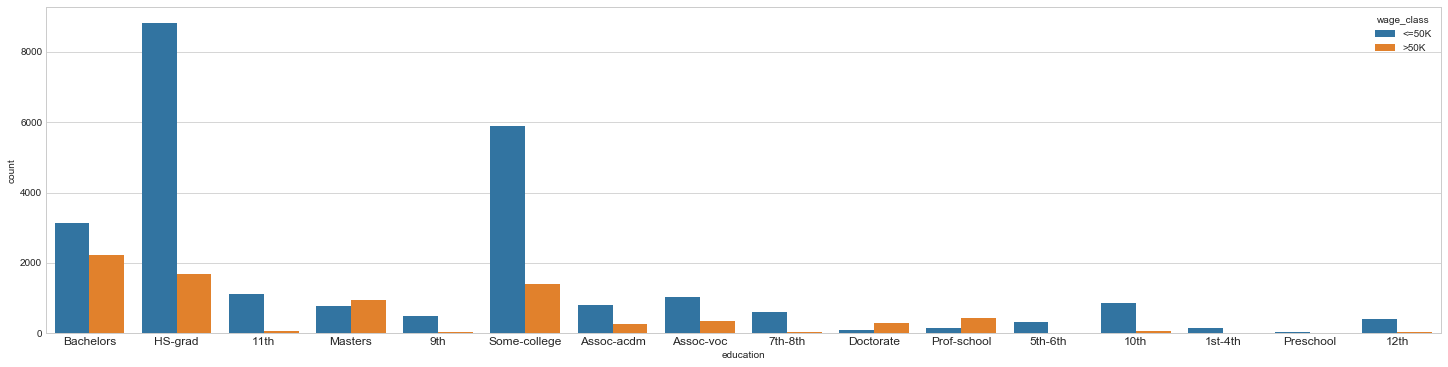

In [33]:
plt.figure(figsize=(25,6))
sns.countplot(adult['education'], hue=adult['wage_class'])

In [34]:
# combine 9th, 10th, 12th, 11TH, 7th-8th, 5th-6th, 1st-4th, Preschol --> pre
# combine Assoc-voc, Assoc-acdm --> assoc
# combine Masters, Doctorate, Prof-school --> grad
# combine Bachelors, HS-grad, Some-college --> post

In [35]:
adult.education.replace(['9th','10th','11th','12th','7th-8th','5th-6th','1st-4th','Preschool','Bachelors','HS-grad','Some-college','Masters','Doctorate','Prog-school','Assoc-voc','Assoc-acdm'],
                       ['pre','pre','pre','pre','pre','pre','pre','pre','post','post','post','grad','grad','grad','assoc','assoc'], inplace=True)

In [36]:
adult.education.value_counts()

post           23147
pre             4253
assoc           2449
grad            2136
Prof-school      576
Name: education, dtype: int64

In [37]:
adult.marital_status.value_counts()

Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: marital_status, dtype: int64

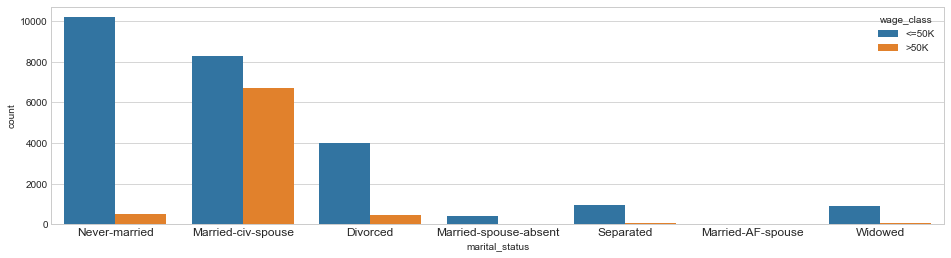

In [38]:
sns.countplot(data=adult, x='marital_status', hue='wage_class')

In [39]:
# combine 'Married-spouse-absent', 'Married-AF-Spouse', Married-civ-spouse', 'Separated', 'Widowed', 'Divorced' --> 'married'
# combine 'Never-married' --> 'unmarried'

In [40]:
adult.marital_status.replace(['Married-spouse-absent', 'Married-AF-spouse', 'Married-civ-spouse', 'Separated', 'Widowed', 'Divorced', 'Never-married'],
                            ['married','married','married','married','married','married','unmarried'], inplace=True)

In [41]:
adult.marital_status.value_counts()

married      21878
unmarried    10683
Name: marital_status, dtype: int64

In [42]:
adult.occupation.value_counts()

Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3770
Sales                3650
Other-service        3295
Machine-op-inspct    2002
missing              1843
Transport-moving     1597
Handlers-cleaners    1370
Farming-fishing       994
Tech-support          928
Protective-serv       649
Priv-house-serv       149
Armed-Forces            9
Name: occupation, dtype: int64

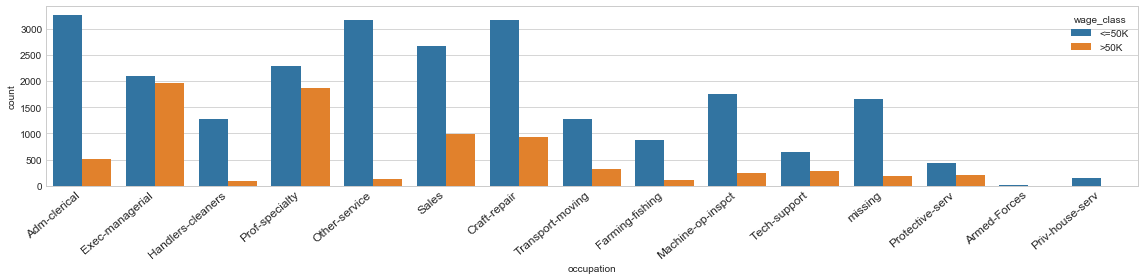

In [43]:
ax = sns.countplot(data=adult, x='occupation', hue='wage_class', orient='h')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()

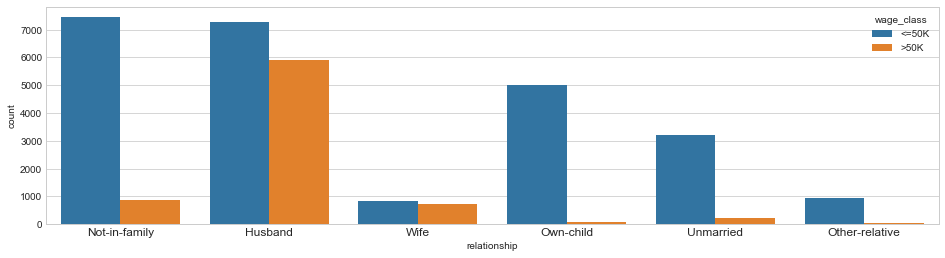

In [44]:
sns.countplot(data=adult, x='relationship', hue='wage_class')

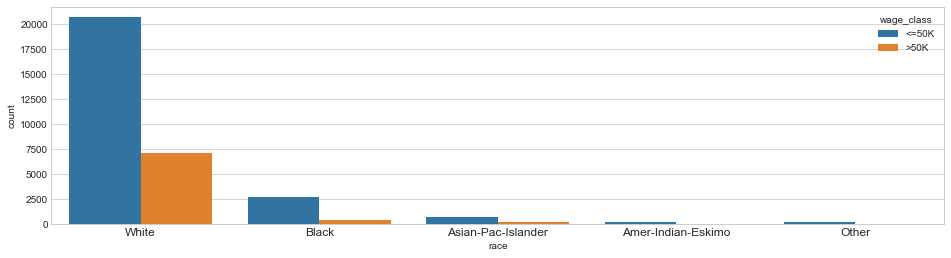

In [45]:
sns.countplot(data=adult, x='race', hue='wage_class')

In [46]:
adult.native_country.value_counts()

United-States                 29170
Mexico                          643
missing                         583
Philippines                     198
Germany                         137
Canada                          121
Puerto-Rico                     114
El-Salvador                     106
India                           100
Cuba                             95
England                          90
Jamaica                          81
South                            80
China                            75
Italy                            73
Dominican-Republic               70
Vietnam                          67
Guatemala                        64
Japan                            62
Poland                           60
Columbia                         59
Taiwan                           51
Haiti                            44
Iran                             43
Portugal                         37
Nicaragua                        34
Peru                             31
Greece                      

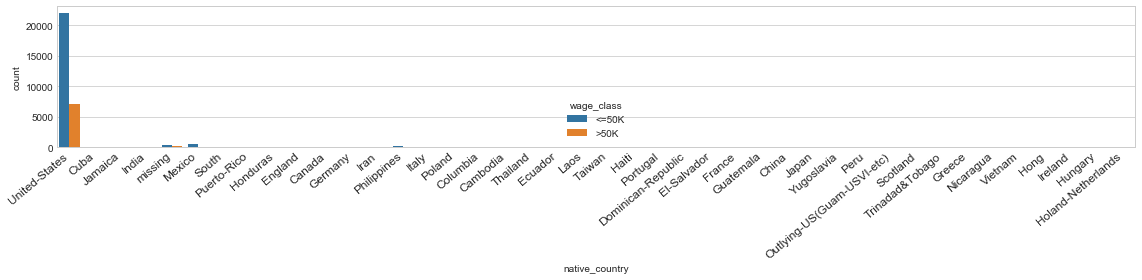

In [47]:
ax = sns.countplot(data=adult, x='native_country', hue='wage_class', orient='h')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()

In [48]:
adult.native_country = adult.native_country.apply(lambda x:'US' if x=='United-States' else 'non-US')

In [49]:
adult.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,gov-emp,77516,post,13,unmarried,Adm-clerical,Not-in-family,White,Male,2174,0,40,US,<=50K
1,50,self-emp,83311,post,13,married,Exec-managerial,Husband,White,Male,0,0,13,US,<=50K
2,38,Private,215646,post,9,married,Handlers-cleaners,Not-in-family,White,Male,0,0,40,US,<=50K
3,53,Private,234721,pre,7,married,Handlers-cleaners,Husband,Black,Male,0,0,40,US,<=50K
4,28,Private,338409,post,13,married,Prof-specialty,Wife,Black,Female,0,0,40,non-US,<=50K


In [50]:
#adult.wage_class = adult.wage_class.apply(lambda x:1 if x=='>50K' else 0)
#adult.sex = adult.sex.apply(lambda x:1 if x=='Male' else 0)

In [52]:
adult = pd.get_dummies(data=adult, columns=['workclass','education','occupation','relationship','race'], prefix=['wc_','ed_','oc_','rel_','race_'])                       

In [53]:
adult = pd.get_dummies(data=adult, columns=['marital_status', 'native_country', 'sex', 'wage_class'], drop_first=True) 

In [54]:
adult.head()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,wc__Private,wc__gov-emp,wc__missing,wc__not-emp,...,rel__Wife,race__Amer-Indian-Eskimo,race__Asian-Pac-Islander,race__Black,race__Other,race__White,marital_status_unmarried,native_country_non-US,sex_Male,wage_class_>50K
0,39,77516,13,2174,0,40,0,1,0,0,...,0,0,0,0,0,1,1,0,1,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,38,215646,9,0,0,40,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
3,53,234721,7,0,0,40,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,28,338409,13,0,0,40,1,0,0,0,...,1,0,0,1,0,0,0,1,0,0


In [55]:
from sklearn.model_selection import train_test_split, cross_validate, ShuffleSplit, GridSearchCV

In [57]:
X= adult.drop('wage_class_>50K', axis=1)
y= adult['wage_class_>50K']

In [58]:
X.head()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,wc__Private,wc__gov-emp,wc__missing,wc__not-emp,...,rel__Unmarried,rel__Wife,race__Amer-Indian-Eskimo,race__Asian-Pac-Islander,race__Black,race__Other,race__White,marital_status_unmarried,native_country_non-US,sex_Male
0,39,77516,13,2174,0,40,0,1,0,0,...,0,0,0,0,0,0,1,1,0,1
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,38,215646,9,0,0,40,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,53,234721,7,0,0,40,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
4,28,338409,13,0,0,40,1,0,0,0,...,0,1,0,0,1,0,0,0,1,0


In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=123)

In [60]:
from xgboost import XGBClassifier

In [61]:
xgb = XGBClassifier(n_estimators=1000, max_depth=6)

In [62]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [64]:
xgb.score(X_train, y_train)

0.9443719287469288

In [65]:
xgb.score(X_test, y_test)

0.8619683709504069

In [66]:
def GridSearch_BestParam(X, y, clf, param_grid,cv=10):
    grid_search = GridSearchCV(clf,
                              param_grid=param_grid,
                              cv=cv)
    start= time.time()
    print(start)
    grid_search.fit(X,y)
    end = time.time()
    print(end)
    #top_params=grid_search.grid_scores_
    #top_params=grid_search.best_scores_
    top_params=grid_search.best_params_
    return top_params

In [67]:
xgb = XGBClassifier()

In [71]:
param_grid3 = {'reg_lambda':[0.3,0.5,0.8,1],
              #'max_features':[3,4],
              'max_depth':[5,7],
              'n_estimators':[300,500,700,1000]
        }
top_para3 = GridSearch_BestParam(X_train, y_train, xgb, param_grid3, cv=10)

1549370444.45
1549380233.07


In [72]:
top_para3

{'max_depth': 5, 'n_estimators': 300, 'reg_lambda': 0.3}

In [73]:
top_para3['max_depth']

5

In [74]:
xgb = XGBClassifier(n_estimators=top_para3['n_estimators'], max_depth=top_para3['max_depth'], reg_lambda=top_para3['reg_lambda'])

In [75]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=300, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=0.3,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [76]:
xgb.score(X_train, y_train)

0.8972665847665847

In [77]:
xgb.score(X_test, y_test)

0.8681099339781975

In [106]:
adult_test = pd.read_csv('adult.test.csv', skiprows=1, header=None, names=['age','workclass','fnlwgt','education','education_num','marital_status','occupation','relationship','race','sex','capital_gain','capital_loss','hours_per_week','native_country','wage_class'])

In [107]:
adult_test.replace(to_replace=' ?', value=np.nan, inplace=True)

In [108]:
for col in categorical:
    adult_test[col] = adult_test[col].str.strip()

adult_test.workclass.fillna('missing', inplace=True)

adult_test.occupation.fillna('missing', inplace=True)

adult_test.native_country.fillna('missing', inplace=True)

In [109]:
adult_test.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,missing,103497,Some-college,10,Never-married,missing,Own-child,White,Female,0,0,30,United-States,<=50K.


In [110]:
adult_test.workclass.replace(['Without-pay','Never-worked','Self-emp-inc','Self-emp-not-inc','State-gov','Federal-gov','Local-gov'],
                       ['not-emp','not-emp','self-emp','self-emp','gov-emp','gov-emp','gov-emp'], inplace=True)
                       
adult_test.education.replace(['9th','10th','11th','12th','7th-8th','5th-6th','1st-4th','Preschool','Bachelors','HS-grad','Some-college','Masters','Doctorate','Prog-school','Assoc-voc','Assoc-acdm'],
                       ['pre','pre','pre','pre','pre','pre','pre','pre','post','post','post','grad','grad','grad','assoc','assoc'], inplace=True)

adult_test.marital_status.replace(['Married-spouse-absent', 'Married-AF-spouse', 'Married-civ-spouse', 'Separated', 'Widowed', 'Divorced', 'Never-married'],
                            ['married','married','married','married','married','married','unmarried'], inplace=True)                       
                       
adult_test.native_country = adult_test.native_country.apply(lambda x:'US' if x=='United-States' else 'non-US')

In [111]:
adult_test.marital_status.value_counts()

married      10847
unmarried     5434
Name: marital_status, dtype: int64

In [112]:
adult_test = pd.get_dummies(data=adult_test, columns=['workclass','education','occupation','relationship','race'], prefix=['wc_','ed_','oc_','rel_','race_'])                       
adult_test = pd.get_dummies(data=adult_test, columns=['marital_status', 'native_country', 'sex', 'wage_class'], drop_first=True)   

In [113]:
adult_test.head()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,wc__Private,wc__gov-emp,wc__missing,wc__not-emp,...,rel__Wife,race__Amer-Indian-Eskimo,race__Asian-Pac-Islander,race__Black,race__Other,race__White,marital_status_unmarried,native_country_non-US,sex_Male,wage_class_>50K.
0,25,226802,7,0,0,40,1,0,0,0,...,0,0,0,1,0,0,1,0,1,0
1,38,89814,9,0,0,50,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,28,336951,12,0,0,40,0,1,0,0,...,0,0,0,0,0,1,0,0,1,1
3,44,160323,10,7688,0,40,1,0,0,0,...,0,0,0,1,0,0,0,0,1,1
4,18,103497,10,0,0,30,0,0,1,0,...,0,0,0,0,0,1,1,0,0,0


In [114]:
X= adult_test.drop('wage_class_>50K.', axis=1)
y= adult_test['wage_class_>50K.']

In [115]:
xgb.predict(X)

array([0, 0, 0, ..., 1, 0, 1], dtype=uint8)

In [116]:
xgb.score(X,y)

0.871875191941527